# Use the VOLVuLuS model to predict segmentation maps
Use a trained 3D U-Net model created by `VOLVuLuS_train.ipynb` to produce segmentation maps for MRA images. 

**Note**: the model consumes almost 11GB during training and at the moment is only capable of using a batch size of 1 volume containing 64 slices. Changing the settings, e.g. using a model with more layers, increasing the batch size or increasing the number of slices in a volume may/will cause an out of memory error.

## Import packages

In [1]:
import VOLVuLuS_settings as settings
from thesis_common import convert_pred_to_img_3d, group_images, show_image, convert_img_to_pred_3d,\
    load_training_3d, load_images_3d
from thesis_metric_loss import evaluate_model, dice_coef_threshold, weighted_pixelwise_crossentropy_loss

from dltoolkit.utils.generic import list_images
from dltoolkit.nn.segment import UNet_3D_NN
from dltoolkit.utils.visual import plot_roc_curve, plot_precision_recall_curve,\
    print_confusion_matrix, print_classification_report

from keras.optimizers import Adam

import os, cv2, shutil, time
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

/Users/geoff/anaconda3/envs/ML3-DL-OPENCV/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Determine test/inference settings
Set `IS_INFERENCE` to `False` to create segmentation maps for test MRA images for which ground truths **are** available. This is typically used to obtain a final test error estimate at the very end of the training process using MRA volumes not used during training. Set it to `False` to apply a trained model to MRA images for which ground truths are **not** available, as would be the case in a production scenario.

During development set `IS_DEVELOPMENT` to `True` to always use the training data set. Then set `USE_TRAINING_SET` to `True` to use the training split or to `False` to use the validation split.

In [2]:
IS_INFERENCE = False
IS_DEVELOPMENT = True
USE_TRAINING_SET = False

if USE_TRAINING_SET:
    # If the validation split is not used override the split value
    settings.TRN_TRAIN_VAL_SPLIT = 0.0

# Path to the trained model to load
Enter the full path to the saved trained model here.

In [3]:
TRAINED_MODEL_NAME = "../savedmodels/VOLVuLuS_UNet3D_2layer_16flt_deconv1_BN_W10.0_ADAM_BS001.model"

# Load data
The cell below performs the actual loading of data. The assumption is that all test data fits into memory, generators are NOT used.

In [4]:
if IS_DEVELOPMENT:    
    if USE_TRAINING_SET:
        print("Using the TRAINING set as the TEST set")
        test_imgs, test_ground_truths, _, _, _, _, _ = load_training_3d(settings)
    else:
        print("Using the VALIDATION set as the TEST set")
        _, _, _, test_imgs, test_ground_truths, _, _ = load_training_3d(settings)
else:
    # Prepare the path to the TEST images and ground truths
    img_path = os.path.join(settings.TEST_PATH, settings.FLDR_IMAGES)
    msk_path = os.path.join(settings.TEST_PATH, settings.FLDR_GROUND_TRUTH)

    # Create a list of paths to the individual patient folders
    patient_fld_imgs = sorted([os.path.join(img_path, e.name)
                               for e in os.scandir(img_path) if e.is_dir()])

    # Load t images
    test_imgs = load_images_3d(patient_fld_imgs, (settings.IMG_HEIGHT, settings.IMG_WIDTH, settings.IMG_CHANNELS),
                               img_exts=settings.IMG_EXTENSION,
                               settings=settings)
    test_imgs = np.transpose(test_imgs, axes=(0, 2, 3, 1, 4))

    if not IS_INFERENCE:
        print("Using a TEST set WITH ground truths")
        patient_fld_masks = sorted([os.path.join(msk_path, e.name)
                                    for e in os.scandir(msk_path) if e.is_dir()])

        test_ground_truths = load_images_3d(patient_fld_masks, (settings.IMG_HEIGHT, settings.IMG_WIDTH, settings.IMG_CHANNELS),
                                            img_exts=settings.IMG_EXTENSION, settings=settings, is_mask=True)
        test_ground_truths = np.transpose(test_ground_truths, axes=(0, 2, 3, 1, 4))
    else:
        print("Using a TEST set WITHOUT ground truths")
        test_ground_truths = None
        
print("\ntest_imgs :", test_imgs.shape)
if test_ground_truths is not None:
    print("test_ground_truths :", test_ground_truths.shape)

Reading images N/A% |                                          | ETA:  --:--:--

Using the VALIDATION set as the TEST set
Loading training images


Reading images 100% |###########################################| Time: 0:00:00
Reading images 100% |###########################################| Time: 0:00:00


Loading training ground truths


Reading images 100% |###########################################| Time: 0:00:00
Reading images N/A% |                                          | ETA:  --:--:--

Elapsed time: 0.21s
Loading validation images
Loading validation ground truths


Reading images 100% |###########################################| Time: 0:00:00


Elapsed time: 0.07s

test_imgs : (1, 256, 256, 64, 1)
test_ground_truths : (1, 256, 256, 64, 1)


# Show one image to check
Show a single image and, if available, its ground truth just as a check.

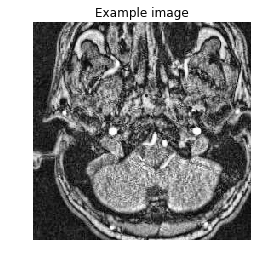

       Max image intensity: 1.0 - float32 - (1, 256, 256, 64, 1)


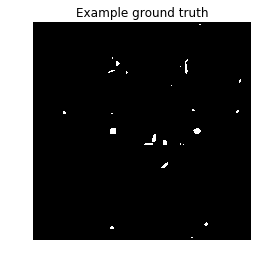

Max ground truth intensity: 255.0 - float32 - (1, 256, 256, 64, 1)


In [5]:
PATIENT_ID = 0
IX = 0

show_image(np.squeeze(test_imgs[PATIENT_ID, :, :, IX, :]), 'Example image')
print("       Max image intensity: {} - {} - {}".format(np.max(test_imgs[PATIENT_ID]),
                                                        test_imgs.dtype,
                                                        test_imgs.shape))

if not IS_INFERENCE or IS_DEVELOPMENT:
    show_image(np.squeeze(test_ground_truths[PATIENT_ID, :, :, IX, :]), 'Example ground truth')
    print("Max ground truth intensity: {} - {} - {}".format(
        np.max(test_ground_truths[PATIENT_ID, :, :, IX, :]),
        test_ground_truths.dtype,
        test_ground_truths.shape))

# Load the trained model
Load the saved model located in the location specified by `TRAINED_MODEL_NAME`. Use the same `build_model_XXX()` method that was used by `VOLVuLuS_training.ipynb` to train the model. Keras is unable to load a model when a different architecture has been loaded.

In [6]:
unet = UNet_3D_NN(img_height=settings.IMG_HEIGHT,
                  img_width=settings.IMG_WIDTH,
                  num_slices=settings.SLICE_END - settings.SLICE_START,
                  img_channels=settings.IMG_CHANNELS,
                  num_classes=settings.NUM_CLASSES)

model = unet.build_model_alt(num_layers=settings.MDL_LAYERS,
                             n_base_filters=settings.MDL_BASE_FLTRS,
                             deconvolution=settings.MDL_DECON,
                             use_bn=settings.MDL_BN)

model.summary()

# Load the weights only
model.load_weights(TRAINED_MODEL_NAME)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 64, 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 256, 256, 64, 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 64, 64          conv3d_1[0][0]                   
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, 256, 256, 64, 13856       batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

# Produce segmentation maps
Predict segmentation maps for all MRA images in the `test_imgs` array and calculate overall loss and metric values.

In [7]:
start_time = time.time()
print("Number of samples: {}".format(test_imgs.shape))
predictions = model.predict(test_imgs, batch_size=settings.TRN_BATCH_SIZE, verbose=2)
print("Elapsed time: {:.2f}s".format(time.time() - start_time))

Number of samples: (1, 256, 256, 64, 1)
Elapsed time: 52.53s


In [8]:
eval_list = evaluate_model(model, test_imgs, test_ground_truths,
                           Adam(lr=settings.TRN_LEARNING_RATE, amsgrad=settings.TRN_AMS_GRAD),
                           weighted_pixelwise_crossentropy_loss,
                           dice_coef_threshold(settings.TRN_PRED_THRESHOLD),
                           convert_img_to_pred_3d, settings)

for name, val in (zip(model.metrics_names, eval_list)):
    print("{} = {:.4f}".format(name, val))

loss = 118736.8750
dice_coef_t = 0.9924


# Convert predictions to segmentation map images
Apply conversions to the predictions for use by various performance assessment functions:

- `predictions_imgs`: Convert the predictions (i.e. scores for both classes for each pixel) to a shape that can be displayed later. A threshold `TRN_PRED_THRESHOLD` is used to determine whether a pixel should be assigned the background or blood vessel class.
- `prediction_scores`: change the order of the dimensions to match (-1, slices, height, width, score)

In [9]:
predictions_imgs = convert_pred_to_img_3d(predictions,
                                       threshold=settings.TRN_PRED_THRESHOLD,
                                       verbose=settings.VERBOSE)
prediction_scores = np.transpose(predictions, axes=(0, 3, 1, 2, 4))

Elapsed time: 0.33s


# Show/save segmentation maps
Display a single MRA image, its ground truth (if available) and the predicted segmentation map. In addition, combine a number of images, ground truths and segmentation maps into a single image (one for each type, three in total) for visualization and save them to disk.

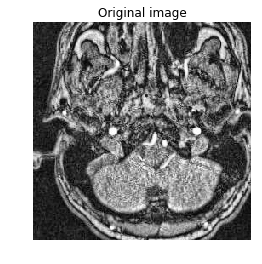

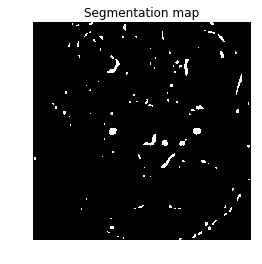

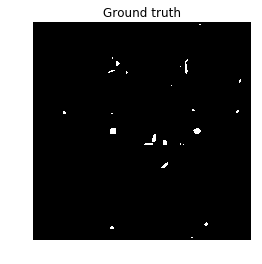

  gr truth 255.0 dtype float32
  original 1.0 dtype float32
prediction 255 dtype uint8


In [10]:
# Show a single image, ground truth and segmentation map
MAX_IMAGES = len(predictions_imgs[PATIENT_ID])

# Change dimensions to (-1, height, width, slices, intensity)
test_imgs_conv = np.transpose(test_imgs, axes=(0, 3, 1, 2, 4)) 
test_ground_truths_conv = np.transpose(test_ground_truths, axes=(0, 3, 1, 2, 4)) 

show_image(np.squeeze(test_imgs_conv[PATIENT_ID, IX]), 'Original image')
show_image(np.squeeze(predictions_imgs[PATIENT_ID, IX]), 'Segmentation map')

# Plot images and segmentation maps in a single image each
group_images(test_imgs_conv[PATIENT_ID, 0:min(16, MAX_IMAGES)],
             4, 1.0, False, "../output/VOLVuLuS_" + unet.title+"_grp_images")
group_images(predictions_imgs[PATIENT_ID, 0:min(16, MAX_IMAGES), :],
             4, 1.0, False, "../output/VOLVuLuS_" + unet.title+"_grp_predictions")

if not IS_INFERENCE or IS_DEVELOPMENT:
    show_image(np.squeeze(test_ground_truths_conv[PATIENT_ID, IX]), 'Ground truth')

    # Plot a number of ground truths in a single image 
    group_images(test_ground_truths_conv[PATIENT_ID, 0:min(16, MAX_IMAGES)],
                 4, 1.0, False, "../output/VOLVuLuS_"+unet.title+"_grp_groundtruths")
    
    print("  gr truth {} dtype {}".format(np.max(test_ground_truths_conv[PATIENT_ID, IX]),
                                          test_ground_truths_conv[0].dtype))

print("  original {} dtype {}".format(np.max(test_imgs_conv[0]), test_imgs_conv[0].dtype))
print("prediction {} dtype {}".format(np.max(predictions_imgs[0]), predictions_imgs[0].dtype))

# Show metrics
The cells below produxe a number of metrics for the current model and the segmentation maps it produced. This is not possible when ground truths are not available.

## ROC curve
Plot the Receiver Operator Characteristic. **Note**: because this is a highly imbalanced data set the ROC curve is **not** a good indicator of performance.


Area under ROC curve: 0.9981


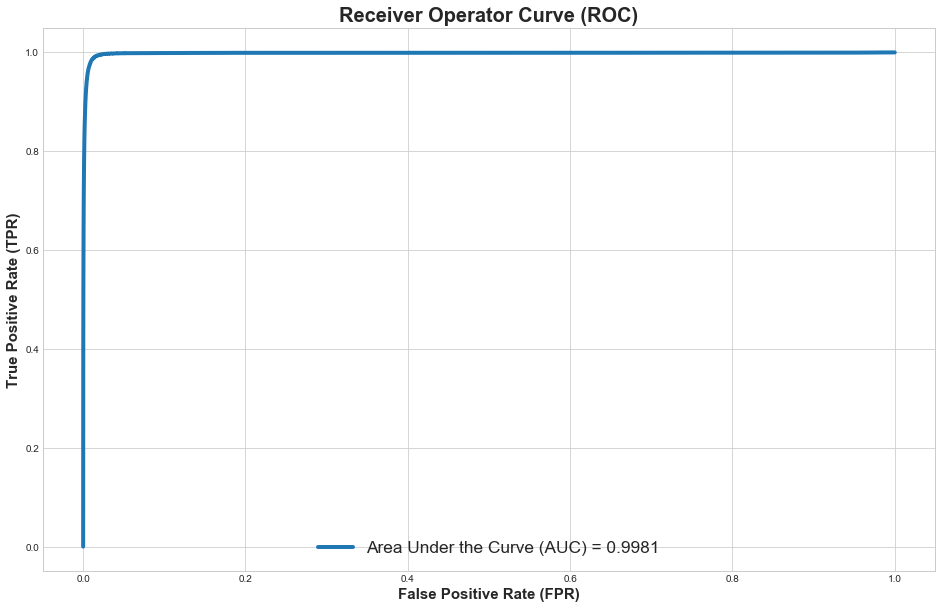

In [11]:
if not IS_INFERENCE or IS_DEVELOPMENT:
    roc_path = os.path.join(settings.OUTPUT_PATH, "VOLVuLuS_" + unet.title)
    plot_roc_curve(test_ground_truths_conv,
                   prediction_scores[:,:,:,:,1],
                   show=True,
                   save_path=roc_path)

## Precision/Recall curve
Plot the Precision/Recall curve. For imbalanced data sets this is a much better performance assessor.


Area under Precision-Recall curve: 0.8696


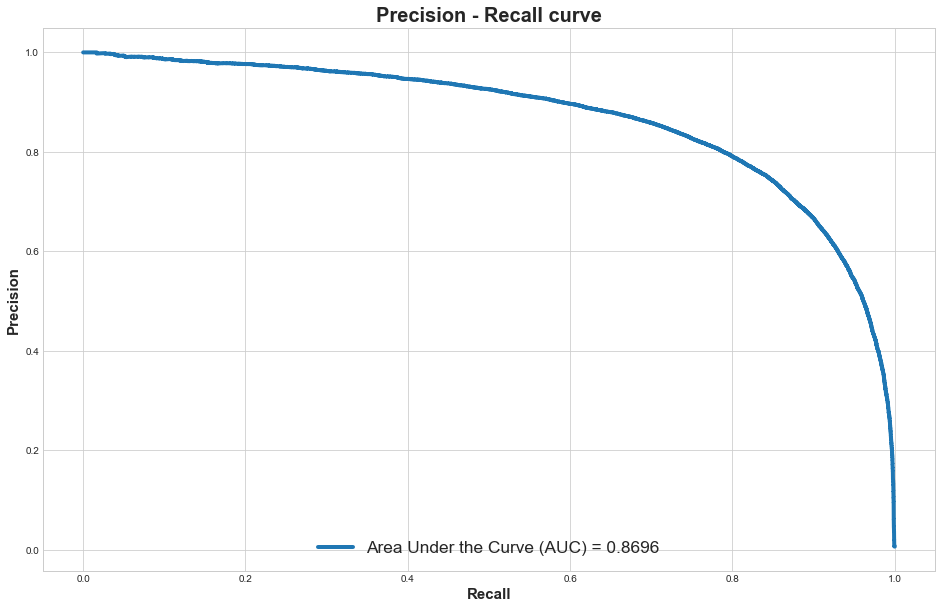

In [12]:
if not IS_INFERENCE or IS_DEVELOPMENT:
    prec_path = os.path.join(settings.OUTPUT_PATH, "VOLVuLuS_" + unet.title)
    plot_precision_recall_curve(test_ground_truths_conv,
                                prediction_scores,
                                settings.NUM_CLASSES,
                                show=True,
                                save_path=prec_path)

## Confusion matrix
Plot the pixel wise confusion matrix.

In [13]:
if not IS_INFERENCE or IS_DEVELOPMENT:
    (conf_ind, conf_mat) = print_confusion_matrix(test_ground_truths_conv, predictions_imgs)

Confusion matrix:
[[4115568   53071]
 [    294   25371]]
   Row/Column: Negative Class, Positive Class, i.e.:
             TN FP
             FN TP

 True Negative (TN): 4115568
 True Positive (TP): 25371
False Negative (FN): 294
False Positive (FP): 53071

Blood vessel precision: 0.32
   Blood vessel recall: 0.99


## Classification report
Plot the pixel wise classification report.

In [14]:
if not IS_INFERENCE or IS_DEVELOPMENT:
    print_classification_report(test_ground_truths_conv, predictions_imgs)

Precision: 0.32
   Recall: 0.99
             precision    recall  f1-score   support

 background       1.00      0.99      0.99   4168639
     vessel       0.32      0.99      0.49     25665

avg / total       1.00      0.99      0.99   4194304



# Write segmentation maps, ground truths and MRA images to disk
Save the predicted segmentation maps, ground truths (after applying the binary mask) and original MRA images to disk.

In [15]:
# Remove existing files
if os.path.exists(settings.SEGMAP_PATH):
    shutil.rmtree(settings.SEGMAP_PATH)
os.makedirs(settings.SEGMAP_PATH)

In [16]:
for patient_id in range(test_imgs_conv.shape[0]):
    for i in range(len(predictions_imgs[patient_id])):
        cv2.imwrite(settings.SEGMAP_PATH + "VOLVuLuS_segmap_p{}_s{}.jpg".format(patient_id, i),
                    predictions_imgs[patient_id, i],
                    (cv2.IMWRITE_JPEG_QUALITY, 100))

    if not IS_INFERENCE or IS_DEVELOPMENT:
        for i in range(len(test_ground_truths_conv[patient_id])):
            cv2.imwrite(settings.SEGMAP_PATH + "VOLVuLuS_groundtruth_p{}_s{}.jpg".format(patient_id, i),
                        test_ground_truths_conv[patient_id, i],
                        (cv2.IMWRITE_JPEG_QUALITY, 100))

    for i in range(len(test_imgs_conv[patient_id])):
        cv2.imwrite(settings.SEGMAP_PATH + "VOLVuLuS_image_p{}_s{}.jpg".format(patient_id, i),
                    test_imgs_conv[patient_id, i].astype(np.float32)*255,
                    (cv2.IMWRITE_JPEG_QUALITY, 100))

# Testing/inference complete